In [1]:
from google.colab import files
uploaded = files.upload()

Saving reverb_dataset.py to reverb_dataset.py
Saving utils.py to utils.py


In [2]:
uploaded = files.upload()

Saving convolutional_models.py to convolutional_models.py
Saving sequential_models.py to sequential_models.py
Saving unet_parts.py to unet_parts.py


In [3]:
!pip install soundfile
!pip install librosa==0.8.0
!pip install scipy==1.5.2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import librosa
import librosa.display as display
import soundfile as sf
import os
import sys
import torch
import cv2

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from utils import generate_spec, reconstruct_wave, graph_spec
from reverb_dataset import ReverbDataset
from convolutional_models import UNetRev, weights_init, Discriminator

     |████████████████████████████████| 25.9MB 51.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


# Data

Need at least 16 GB RAM for the 4 tensors. You can generate the tensors with data_generation notebooks (Generate_spectrograms.ipynb and Normalize_spectrograms.ipynb)

Load a smaller file number (for train) if you have less RAM

In [ ]:
X_train1 = torch.load('/content/drive/My Drive/data_audio/X_train_1')
X_train2 = torch.load('/content/drive/My Drive/data_audio/X_train_2')
X_train3 = torch.load('/content/drive/My Drive/data_audio/X_train_3')
X_train4 = torch.load('/content/drive/My Drive/data_audio/X_train_4')
y_train1 = torch.load('/content/drive/My Drive/data_audio/y_train_1')
y_train2 = torch.load('/content/drive/My Drive/data_audio/y_train_2')
y_train3 = torch.load('/content/drive/My Drive/data_audio/y_train_3')
y_train4 = torch.load('/content/drive/My Drive/data_audio/y_train_4')

In [ ]:
X = torch.cat((X_train1, X_train2, X_train3, X_train4))
y = torch.cat((y_train1, y_train2, y_train3, y_train4))

In [ ]:
total_dataset = ReverbDataset(X, y)
length_train = int(len(total_dataset)*0.85)
length_val = len(total_dataset) - length_train
lengths = [length_train, length_val]
dataset_train, dataset_val = random_split(total_dataset, lengths)

# Training

In [ ]:
def trainer(G_net, D_net, train_loader, checkpoints, nEpochs = 100, lr_disc = 1e-3, lr_gen = 1e-3, batch_size = 16, lambda_hyper = 1e-3):

  """
  Train model

  model: GAN using U-net generator
  train_loader: dataloader containing train examples
  val_loader: dataloader containing validation examples
  checkpoints: list of directories to save the model, train loss and Val loss respectively
  """

  beta1 = 0.5
  beta2 = 0.999
  lr_decay = 0.97
  decay_rate = 2

  # Loss function
  binary_cross_entropy = nn.BCEWithLogitsLoss()
  #binary_cross_entropy = nn.BCELoss()
  mse_loss = nn.MSELoss()

  # Optimizers
  D_optimizer = torch.optim.Adam(D_net.parameters(), lr = lr_disc, betas=(beta1, beta2))
  G_optimizer = torch.optim.Adam(G_net.parameters(), lr = lr_gen, betas=(beta1, beta2))


  gen_bce_loss = []
  disc_loss = []
  gen_mse_loss = []
  iterations = 0
  
  G_net.train()
  D_net.train()
  for epoch in range(nEpochs):
    for i, (rev_data, clean_data) in enumerate(train_loader):
      iterations += 1
      rev_data = rev_data.cuda()
      clean_data = clean_data.cuda()
      label_discriminator = torch.FloatTensor(rev_data.shape[0], 1).cuda()

      
      ### Discriminator optimization
      D_optimizer.zero_grad()

      # True sample
      label_discriminator.fill_(1)
      true_pred = D_net(clean_data)
      true_loss = binary_cross_entropy(true_pred, label_discriminator) 
      true_loss.backward()

      # Fake sample
      label_discriminator.fill_(0)
      fake_sample = G_net(rev_data)
      fake_pred = D_net(fake_sample.detach())
      fake_loss = binary_cross_entropy(fake_pred, label_discriminator)
      fake_loss.backward()
      # Discriminator loss
      discriminator_loss = true_loss + fake_loss

      if (iterations<=500):
        D_optimizer.step()

      ### Generator optimization
      G_optimizer.zero_grad()
      label_discriminator.fill_(1)
      fake_sample = G_net(rev_data)
      fake_pred = D_net(fake_sample.detach())
      G_bce_loss = binary_cross_entropy(fake_pred, label_discriminator)
      G_mse_loss = lambda_hyper*mse_loss(fake_sample, clean_data)

      generator_loss = G_bce_loss + G_mse_loss
      generator_loss.backward()
      G_optimizer.step()

      gen_bce_loss.append(G_bce_loss.item())
      disc_loss.append(discriminator_loss.item())
      gen_mse_loss.append(G_mse_loss.item())

    print('Epoch : {} || Generator BCE Loss: {:.3f} || Discriminator BCE Loss: {:.3f} || Generator MSE Loss: {:.3f}'\
         .format(epoch+1, G_bce_loss.item(), discriminator_loss.item(), G_mse_loss.item()))
    
    if ((epoch+1)%5 == 0):
      torch.save(G_net, checkpoints[0])
      torch.save(gen_bce_loss, checkpoints[1])
      torch.save(disc_loss, checkpoints[2])
      torch.save(gen_mse_loss, checkpoints[3])
      print("saved models")

    if (epoch % decay_rate == 1):
       D_optimizer.param_groups[0]['lr'] *= lr_decay
       G_optimizer.param_groups[0]['lr'] *= lr_decay

  return gen_bce_loss, gen_mse_loss, disc_loss

In [ ]:
train_loader = DataLoader(dataset_train, batch_size = 16, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(dataset_val, batch_size = 16, shuffle = True, num_workers = 4, pin_memory = True)

In [ ]:
checkpoints = ['/content/drive/My Drive/data_audio/model_gan2', '/content/drive/My Drive/data_audio/gen_loss2', 
               '/content/drive/My Drive/data_audio/disc_loss2', '/content/drive/My Drive/data_audio/recon_loss2']

gen_net = UNetRev(1, bilinear=False, confine = False)
disc_net = Discriminator()
gen_net.apply(weights_init)
disc_net.apply(weights_init)

losses = trainer(gen_net.cuda(), disc_net.cuda(), train_loader, checkpoints, nEpochs = 10, lr_disc = 1e-3, lr_gen = 1e-3, lambda_hyper=1e-2)

Epoch : 1 || Generator BCE Loss: 0.782 || Discriminator BCE Loss: 1.403 || Generator MSE Loss: 0.222
Epoch : 2 || Generator BCE Loss: 0.771 || Discriminator BCE Loss: 1.418 || Generator MSE Loss: 0.229
Epoch : 3 || Generator BCE Loss: 0.834 || Discriminator BCE Loss: 1.407 || Generator MSE Loss: 0.258
Epoch : 4 || Generator BCE Loss: 0.778 || Discriminator BCE Loss: 1.398 || Generator MSE Loss: 0.191
Epoch : 5 || Generator BCE Loss: 0.843 || Discriminator BCE Loss: 1.403 || Generator MSE Loss: 0.233
saved models
Epoch : 6 || Generator BCE Loss: 0.845 || Discriminator BCE Loss: 1.404 || Generator MSE Loss: 0.156
Epoch : 7 || Generator BCE Loss: 0.736 || Discriminator BCE Loss: 1.410 || Generator MSE Loss: 0.166
Epoch : 8 || Generator BCE Loss: 0.855 || Discriminator BCE Loss: 1.411 || Generator MSE Loss: 0.148
Epoch : 9 || Generator BCE Loss: 0.840 || Discriminator BCE Loss: 1.414 || Generator MSE Loss: 0.146
Epoch : 10 || Generator BCE Loss: 0.781 || Discriminator BCE Loss: 1.386 || Ge

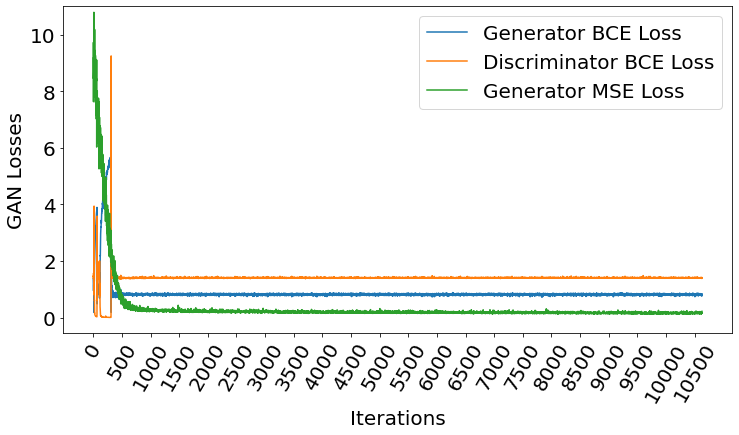

In [ ]:
gen_loss = torch.load('/content/drive/My Drive/data_audio/gen_loss2')
disc_loss = torch.load('/content/drive/My Drive/data_audio/disc_loss2')
recon_loss = torch.load('/content/drive/My Drive/data_audio/recon_loss2')
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize = (12, 6))
plt.plot(gen_loss, label = 'Generator BCE Loss')
plt.plot(disc_loss, label = 'Discriminator BCE Loss') #noisy loss
plt.plot(recon_loss, label = 'Generator MSE Loss')
plt.ylim(top = 11)
plt.xlabel('Iterations')
plt.ylabel('GAN Losses')
plt.xticks(ticks = np.arange(0, len(gen_loss), 500), rotation=60)
plt.legend()
plt.show()

# Qualitative Evaluation

In [5]:
def evaluate_qualitative(model_G, audio_dirs, num_example, speech_rate=16000):
  """
  net: Unet generator model on CPU
  audio_dirs: list of directories containing reverberant spectrograms, clean spectrograms,
              reverberant waveforms and clean waveforms respectively
  num_example: example number in data
  speech_rate: sampling rate of speech data  
  """
  
  matplotlib.rc('xtick', labelsize=15) 
  matplotlib.rc('ytick', labelsize=15)
  matplotlib.rcParams.update({'font.size': 15})

  X_test = torch.load(audio_dirs[0])
  y_test = torch.load(audio_dirs[1])
  waves = torch.load(audio_dirs[2])
  waves_target = torch.load(audio_dirs[3])
  dataset_test = ReverbDataset(X_test, y_test)

  original_spec = generate_spec(waves[num_example], speech_rate)
  clean_spec = generate_spec(waves_target[num_example], speech_rate)
  original_size = original_spec.shape

  original_spec = generate_spec(waves[num_example], speech_rate)
  clean_spec = generate_spec(waves_target[num_example], speech_rate)
  original_size = original_spec.shape

  ex = dataset_test.__getitem__(num_example)[0]
  rev_spec = ex[0].numpy()
  example = torch.zeros((1, 1, ex.shape[1], ex.shape[2]))
  example[0, :, :, :] = ex
  model_G.eval()
  derev = model_G(example)

  derev = derev.clone().detach().cpu().numpy()
  derev = derev[0, 0, :, :]
  derev = cv2.resize(derev, dsize = (original_size[1], original_size[0]), interpolation = cv2.INTER_LANCZOS4)

  graph_spec(original_spec)
  graph_spec(clean_spec)
  graph_spec(derev)

In [ ]:
model_G = torch.load('/content/drive/My Drive/data_audio/model_gan2', map_location=lambda storage, loc: storage)
dir_list = ['/content/drive/My Drive/data_audio/X_test', '/content/drive/My Drive/data_audio/y_test',
            '/content/drive/My Drive/data_audio/waverev', '/content/drive/My Drive/data_audio/wavetarget']

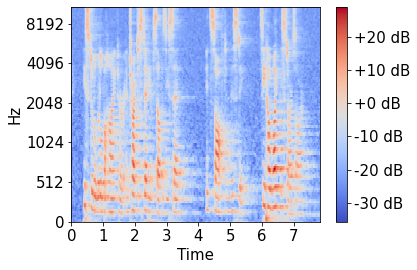

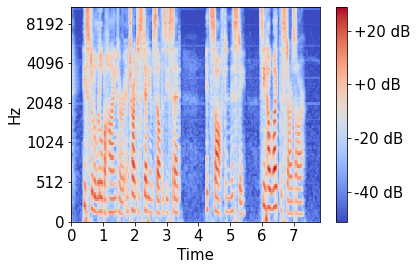

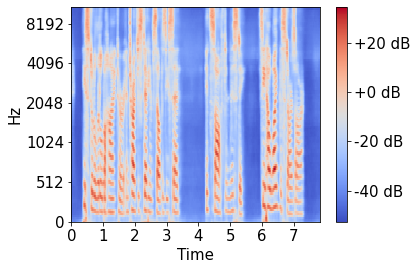

In [ ]:
evaluate_qualitative(model_G, dir_list, 100)

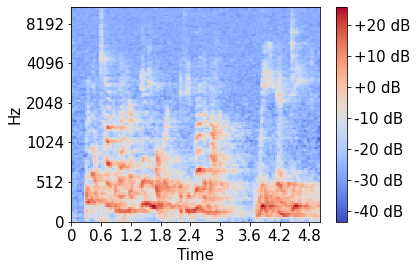

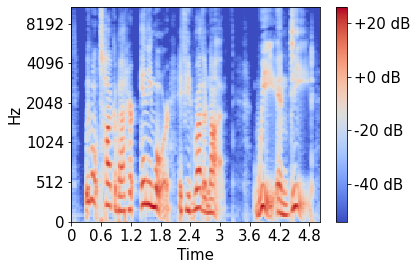

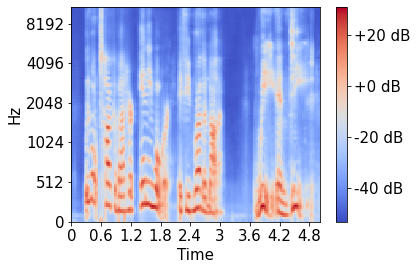

In [ ]:
evaluate_qualitative(model_G, dir_list, 300)

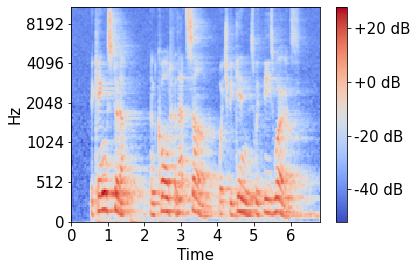

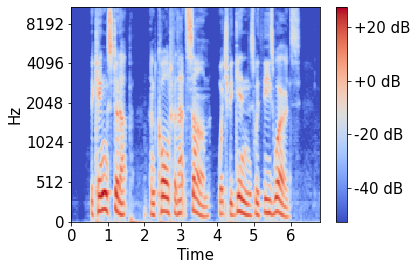

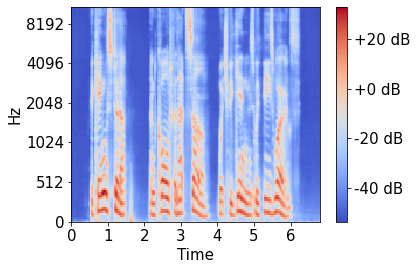

In [ ]:
evaluate_qualitative(model_G, dir_list, 400)

# Quantitative Evaluation

In [ ]:
!pip3 install https://github.com/schmiph2/pysepm/archive/master.zip

     | 2.2MB 2.5MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     - 337kB 56.0MB/s
     / 81kB 53.1MB/s
     - 65.8MB 2.0MB/s
     |████████████████████████████████| 163kB 11.4MB/s 
  Created wheel for pysepm: filename=pysepm-0.1-cp37-none-any.whl size=24291 sha256=bf704598932391b5ab6af7e8b92b1c8cff3b7758dc26105b00ebb5d1935c1215
  Stored in directory: /tmp/pip-ephem-wheel-cache-s46n80o8/wheels/17/75/23/17712e0da834688ac430e0cf826dd1f7450d0b4873e0269f7c
Successfully built pysepm
  Created wheel for pesq: filename=pesq-0.0.2-cp37-cp37m-linux_x86_64.whl size=162258 sha256=cb318a8119f4d8236ca1bcd3aab26e1f2ad912327a19cf6dc1bb119947ee6b8f
  Stored in directory: /tmp/pip-ephem-wheel-cache-s46n80o8/wheels/85/91/09/5ae7677a054a05d49111dc8f3b282e886b3852348384893a32
  Created wheel for pystoi: filename=pystoi-0.3.3-py2.py3-none-any.whl size=7781 sha256=23cad47bd7138f223aab91525c5a44b1e8b1253c2f61880680424f0b135

In [ ]:
!pip install pystoi
!pip install pypesq
from pysepm import *
from pystoi import stoi
from pypesq import pesq

  Created wheel for pypesq: filename=pypesq-1.2.4-cp37-cp37m-linux_x86_64.whl size=84232 sha256=678d2d79613fc7f830d1be54540a0e83841e0a14c4f6d2b37ed03ef4a2baa0e9
  Stored in directory: /root/.cache/pip/wheels/c9/29/a6/ed19583426cffac50b3e75160f894120a49f9bafa585a2edbe
Successfully built pypesq


In [ ]:
def evaluate(net, dataset, path, path_waves, init_example, end_example, speech_rate = 16000, initial = True, normalize_data = False):
  """
  net: U-net model used as generator
  dataset: reverb_dataset object to extract examples
  path: base directory to save results
  path_waves: directory containing reverb waveforms (not recovered from spectrograms)
  init_example: first example in dataset to be considered
  end_example: last example in dataset to be considered
  speech_rate: sampling rate of speech audios
  initial: True if is the first time executing, False if is not the first time
           if is False the new results are added to the existing results
  normalize_data: True if the net assumed normalized input 
  """

  device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
  print('Current device: ' + str(device))

  if (initial):
    reverb_pesq_list = []
    reverb_stoi_list = []
    reverb_llr_list = []
    reverb_cd_list = []
    reverb_fwSNRseg_list = []
    reverb_srmr_list = []

    dereverb_pesq_list = []
    dereverb_stoi_list = []
    dereverb_llr_list = []
    dereverb_cd_list = []
    dereverb_fwSNRseg_list = []
    dereverb_srmr_list = []
  
  else:
    reverb_pesq_list = torch.load(path + 'reverb_pesq_gan')
    reverb_stoi_list = torch.load(path + 'reverb_stoi_gan')
    reverb_llr_list = torch.load(path + 'reverb_llr_gan')
    reverb_cd_list = torch.load(path + 'reverb_cd_gan')
    reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_gan')
    reverb_srmr_list = torch.load(path + 'reverb_srmr_gan')

    dereverb_pesq_list = torch.load(path + 'dereverb_pesq_gan')
    dereverb_stoi_list = torch.load(path + 'dereverb_stoi_gan')
    dereverb_llr_list = torch.load(path + 'dereverb_llr_gan')
    dereverb_cd_list = torch.load(path + 'dereverb_cd_gan')
    dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_gan')
    dereverb_srmr_list = torch.load(path + 'dereverb_srmr_gan')
  
  waves = torch.load(path_waves)
  net.eval()
  for i in range(init_example, end_example):
    print("Processing Example n°{}".format(i+1))
    real_spec = generate_spec(waves[i], speech_rate)
    rev_spec, clean_spec = dataset.__getitem__(i)
    clean_spec = clean_spec[0, :, :]
    net_input = torch.zeros((1, 1, rev_spec.shape[1], rev_spec.shape[2]))

    if normalize_data:
      norm_example, norm_stats_rev = linear_scaler(rev_spec[0, :, :].numpy())
      net_input[0, 0, :, :] = torch.tensor(norm_example)
      net_response = net(net_input.to(device))
      net_response = net_response.clone().detach().cpu().numpy() if torch.cuda.is_available() else net_response.clone().detach().numpy()
      net_response = (net_response-norm_stats_rev[1])/norm_stats_rev[0]


    else:
      net_input[0, :, :, :] = rev_spec
      net_response = net(net_input.to(device))
      net_response = net_response.clone().detach().cpu().numpy() if torch.cuda.is_available() else net_response.clone().detach().numpy()
  
    
    try:
      net_response = net_response[0, 0, :, :]
      recon_spec = cv2.resize(net_response, dsize = (real_spec.shape[1], real_spec.shape[0]), interpolation = cv2.INTER_LANCZOS4)
      clean_spec = cv2.resize(clean_spec.numpy(), dsize = (real_spec.shape[1], real_spec.shape[0]), interpolation = cv2.INTER_LANCZOS4)
      rev_spec = cv2.resize(rev_spec[0, :, :].numpy(), dsize = (real_spec.shape[1], real_spec.shape[0]), interpolation = cv2.INTER_LANCZOS4)

      original = reconstruct_wave(clean_spec)
      reverb = reconstruct_wave(rev_spec)
      recon = reconstruct_wave(recon_spec)
      recon_srmr = recon

      pesq_metric_rev = pesq(original[0:len(reverb)], reverb, fs = speech_rate)
      stoi_metric_rev = stoi(original[0:len(reverb)], reverb, speech_rate)
      llr_metric_rev = llr(original[0:len(reverb)], reverb, speech_rate)
      cd_metric_rev = cepstrum_distance(original[0:len(reverb)], reverb, speech_rate)
      fwSNRseg_metric_rev = fwSNRseg(original[0:len(reverb)], reverb, speech_rate)
      srmr_metric_rev = srmr(waves[i], speech_rate)

      pesq_metric_recon = pesq(original[0:len(recon)], recon, fs = speech_rate)
      stoi_metric_recon = stoi(original[0:len(recon)], recon, speech_rate)
      llr_metric_recon = llr(original[0:len(recon)], recon, speech_rate)
      cd_metric_recon = cepstrum_distance(original[0:len(recon)], recon, speech_rate)
      fwSNRseg_metric_recon = fwSNRseg(original[0:len(recon)], recon, speech_rate)
      srmr_metric_recon = srmr(recon_srmr, speech_rate)

      reverb_pesq_list.append(pesq_metric_rev)
      reverb_stoi_list.append(stoi_metric_rev)
      reverb_llr_list.append(llr_metric_rev)
      reverb_cd_list.append(cd_metric_rev)
      reverb_fwSNRseg_list.append(fwSNRseg_metric_rev)
      reverb_srmr_list.append(srmr_metric_rev)

      dereverb_pesq_list.append(pesq_metric_recon)
      dereverb_stoi_list.append(stoi_metric_recon)
      dereverb_llr_list.append(llr_metric_recon)
      dereverb_cd_list.append(cd_metric_recon)
      dereverb_fwSNRseg_list.append(fwSNRseg_metric_recon)
      dereverb_srmr_list.append(srmr_metric_recon)

      print('PESQ reverberated signal: {:.3f} || PESQ dereverberated signal: {:.3f}'.format(pesq_metric_rev, pesq_metric_recon))
      print('STOI reverberated signal: {:.3f} || STOI dereverberated signal: {:.3f}'.format(stoi_metric_rev, stoi_metric_recon))
      print('LLR reverberated signal: {:.3f} || LLR dereverberated signal: {:.3f}'.format(llr_metric_rev, llr_metric_recon))
      print('CD reverberated signal: {:.3f} || CD dereverberated signal: {:.3f}'.format(cd_metric_rev, cd_metric_recon))
      print('fwSNRseg reverberated signal: {:.3f} || fwSNRseg dereverberated signal: {:.3f}'.format(fwSNRseg_metric_rev, fwSNRseg_metric_recon))
      print('SRMR reverberated signal: {:.3f} || SRMR dereverberated signal: {:.3f}'.format(srmr_metric_rev, srmr_metric_recon))
      print('\n')
    except librosa.feature.inverse.ParameterError: 
      pass

    if ((i+1)%10 == 0):
      torch.save(reverb_pesq_list, path + 'reverb_pesq_gan')
      torch.save(reverb_stoi_list, path + 'reverb_stoi_gan')
      torch.save(reverb_llr_list, path + 'reverb_llr_gan')
      torch.save(reverb_cd_list, path + 'reverb_cd_gan')
      torch.save(reverb_fwSNRseg_list, path + 'reverb_fwSNRseg_gan')
      torch.save(reverb_srmr_list, path + 'reverb_srmr_gan')

      torch.save(dereverb_pesq_list, path + 'dereverb_pesq_gan')
      torch.save(dereverb_stoi_list, path + 'dereverb_stoi_gan')
      torch.save(dereverb_llr_list, path + 'dereverb_llr_gan')
      torch.save(dereverb_cd_list, path + 'dereverb_cd_gan')
      torch.save(dereverb_fwSNRseg_list, path + 'dereverb_fwSNRseg_gan')
      torch.save(dereverb_srmr_list, path + 'dereverb_srmr_gan')
      
      print('Saved')
      print('\n')

## Room Simulated 1

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room1/'
path_waves = '/content/drive/My Drive/data_audio/waverev'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test')
model_G = torch.load('/content/drive/My Drive/data_audio/model_gan2', map_location=lambda storage, loc: storage)
dataset_test = ReverbDataset(X_test, y_test)
evaluate(model_G, dataset_test, path, path_waves, 0, 500, initial = True, normalize_data=False)

Current device: cpu
Processing Example n°1
PESQ reverberated signal: 2.124 || PESQ dereverberated signal: 2.882
STOI reverberated signal: 0.750 || STOI dereverberated signal: 0.849
LLR reverberated signal: 0.436 || LLR dereverberated signal: 0.300
CD reverberated signal: 3.841 || CD dereverberated signal: 3.028
fwSNRseg reverberated signal: 8.363 || fwSNRseg dereverberated signal: 11.056
SRMR reverberated signal: 2.961 || SRMR dereverberated signal: 5.069


Processing Example n°2
PESQ reverberated signal: 2.046 || PESQ dereverberated signal: 2.688
STOI reverberated signal: 0.719 || STOI dereverberated signal: 0.822
LLR reverberated signal: 0.472 || LLR dereverberated signal: 0.327
CD reverberated signal: 4.049 || CD dereverberated signal: 3.130
fwSNRseg reverberated signal: 7.552 || fwSNRseg dereverberated signal: 10.118
SRMR reverberated signal: 3.543 || SRMR dereverberated signal: 5.417


Processing Example n°3
PESQ reverberated signal: 1.971 || PESQ dereverberated signal: 2.690
STOI

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room1/'
path_waves = '/content/drive/My Drive/data_audio/waverev'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test')
model_G = torch.load('/content/drive/My Drive/data_audio/model_gan2', map_location=lambda storage, loc: storage)
dataset_test = ReverbDataset(X_test, y_test)
evaluate(model_G, dataset_test, path, path_waves, 320, 500, initial = False, normalize_data=False)

Current device: cpu
Processing Example n°321
PESQ reverberated signal: 2.028 || PESQ dereverberated signal: 2.644
STOI reverberated signal: 0.751 || STOI dereverberated signal: 0.848
LLR reverberated signal: 1.005 || LLR dereverberated signal: 0.449
CD reverberated signal: 6.237 || CD dereverberated signal: 3.781
fwSNRseg reverberated signal: 7.371 || fwSNRseg dereverberated signal: 9.745
SRMR reverberated signal: 2.866 || SRMR dereverberated signal: 5.554


Processing Example n°322
PESQ reverberated signal: 1.999 || PESQ dereverberated signal: 2.543
STOI reverberated signal: 0.744 || STOI dereverberated signal: 0.859
LLR reverberated signal: 0.802 || LLR dereverberated signal: 0.432
CD reverberated signal: 5.358 || CD dereverberated signal: 3.670
fwSNRseg reverberated signal: 7.839 || fwSNRseg dereverberated signal: 9.561
SRMR reverberated signal: 2.861 || SRMR dereverberated signal: 5.745


Processing Example n°323
PESQ reverberated signal: 2.054 || PESQ dereverberated signal: 2.631


In [ ]:
path = '/content/drive/My Drive/metrics_audio/room1/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_gan')
reverb_stoi_list = torch.load(path + 'reverb_stoi_gan')
reverb_llr_list = torch.load(path + 'reverb_llr_gan')
reverb_cd_list = torch.load(path + 'reverb_cd_gan')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_gan')
reverb_srmr_list = torch.load(path + 'reverb_srmr_gan')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_gan')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_gan')
dereverb_llr_list = torch.load(path + 'dereverb_llr_gan')
dereverb_cd_list = torch.load(path + 'dereverb_cd_gan')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_gan')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_gan')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.02
STOI: 0.75
LLR: 0.80
CD: 5.35
fwSNRseg: 7.14
SRMR: 3.14

Dereverberated signal:
PESQ: 2.67
STOI: 0.85
LLR: 0.44
CD: 3.68
fwSNRseg: 9.78
SRMR: 7.10


## Room Simulated 2

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room2/'
path_waves = '/content/drive/My Drive/data_audio/waverev_2'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_2')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_2')
model_G = torch.load('/content/drive/My Drive/data_audio/model_gan2', map_location=lambda storage, loc: storage)
dataset_test = ReverbDataset(X_test, y_test)
evaluate(model_G, dataset_test, path, path_waves, 0, 500, initial = True, normalize_data=False)

Current device: cpu
Processing Example n°1
PESQ reverberated signal: 2.109 || PESQ dereverberated signal: 2.329
STOI reverberated signal: 0.592 || STOI dereverberated signal: 0.634
LLR reverberated signal: 1.007 || LLR dereverberated signal: 0.740
CD reverberated signal: 5.831 || CD dereverberated signal: 4.939
fwSNRseg reverberated signal: 7.072 || fwSNRseg dereverberated signal: 7.704
SRMR reverberated signal: 2.991 || SRMR dereverberated signal: 3.415


Processing Example n°2
PESQ reverberated signal: 2.144 || PESQ dereverberated signal: 2.337
STOI reverberated signal: 0.610 || STOI dereverberated signal: 0.645
LLR reverberated signal: 0.989 || LLR dereverberated signal: 0.686
CD reverberated signal: 5.514 || CD dereverberated signal: 4.653
fwSNRseg reverberated signal: 6.692 || fwSNRseg dereverberated signal: 7.330
SRMR reverberated signal: 2.799 || SRMR dereverberated signal: 3.091


Processing Example n°3
PESQ reverberated signal: 2.047 || PESQ dereverberated signal: 2.295
STOI r

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room2/'
path_waves = '/content/drive/My Drive/data_audio/waverev_2'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_2')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_2')
model_G = torch.load('/content/drive/My Drive/data_audio/model_gan2', map_location=lambda storage, loc: storage)
dataset_test = ReverbDataset(X_test, y_test)
evaluate(model_G, dataset_test, path, path_waves, 150, 500, initial = False, normalize_data=False)

Current device: cpu
Processing Example n°151
PESQ reverberated signal: 2.087 || PESQ dereverberated signal: 2.317
STOI reverberated signal: 0.597 || STOI dereverberated signal: 0.667
LLR reverberated signal: 0.958 || LLR dereverberated signal: 0.656
CD reverberated signal: 5.810 || CD dereverberated signal: 4.765
fwSNRseg reverberated signal: 6.645 || fwSNRseg dereverberated signal: 7.734
SRMR reverberated signal: 4.689 || SRMR dereverberated signal: 6.893


Processing Example n°152
PESQ reverberated signal: 1.794 || PESQ dereverberated signal: 2.113
STOI reverberated signal: 0.566 || STOI dereverberated signal: 0.616
LLR reverberated signal: 1.021 || LLR dereverberated signal: 0.725
CD reverberated signal: 6.009 || CD dereverberated signal: 4.929
fwSNRseg reverberated signal: 6.252 || fwSNRseg dereverberated signal: 7.354
SRMR reverberated signal: 6.114 || SRMR dereverberated signal: 8.498


Processing Example n°153
PESQ reverberated signal: 1.992 || PESQ dereverberated signal: 2.264


In [ ]:
path = '/content/drive/My Drive/metrics_audio/room2/'
path_waves = '/content/drive/My Drive/data_audio/waverev_2'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_2')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_2')
model_G = torch.load('/content/drive/My Drive/data_audio/model_gan2', map_location=lambda storage, loc: storage)
dataset_test = ReverbDataset(X_test, y_test)
evaluate(model_G, dataset_test, path, path_waves, 360, 500, initial = False, normalize_data=False)

Current device: cpu
Processing Example n°361
PESQ reverberated signal: 2.047 || PESQ dereverberated signal: 2.420
STOI reverberated signal: 0.582 || STOI dereverberated signal: 0.657
LLR reverberated signal: 0.973 || LLR dereverberated signal: 0.597
CD reverberated signal: 5.507 || CD dereverberated signal: 4.515
fwSNRseg reverberated signal: 5.707 || fwSNRseg dereverberated signal: 7.415
SRMR reverberated signal: 3.406 || SRMR dereverberated signal: 4.932


Processing Example n°362
PESQ reverberated signal: 2.125 || PESQ dereverberated signal: 2.420
STOI reverberated signal: 0.615 || STOI dereverberated signal: 0.672
LLR reverberated signal: 0.991 || LLR dereverberated signal: 0.581
CD reverberated signal: 5.417 || CD dereverberated signal: 4.325
fwSNRseg reverberated signal: 6.068 || fwSNRseg dereverberated signal: 7.257
SRMR reverberated signal: 4.118 || SRMR dereverberated signal: 5.734


Processing Example n°363
PESQ reverberated signal: 2.087 || PESQ dereverberated signal: 2.368


In [ ]:
path = '/content/drive/My Drive/metrics_audio/room2/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_gan')
reverb_stoi_list = torch.load(path + 'reverb_stoi_gan')
reverb_llr_list = torch.load(path + 'reverb_llr_gan')
reverb_cd_list = torch.load(path + 'reverb_cd_gan')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_gan')
reverb_srmr_list = torch.load(path + 'reverb_srmr_gan')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_gan')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_gan')
dereverb_llr_list = torch.load(path + 'dereverb_llr_gan')
dereverb_cd_list = torch.load(path + 'dereverb_cd_gan')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_gan')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_gan')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.06
STOI: 0.60
LLR: 0.92
CD: 5.53
fwSNRseg: 6.62
SRMR: 4.49

Dereverberated signal:
PESQ: 2.36
STOI: 0.66
LLR: 0.64
CD: 4.56
fwSNRseg: 7.63
SRMR: 6.19


## Room Simulated 3

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room3/'
path_waves = '/content/drive/My Drive/data_audio/waverev_3'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_3')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_3')
model_G = torch.load('/content/drive/My Drive/data_audio/model_gan2', map_location=lambda storage, loc: storage)
dataset_test = ReverbDataset(X_test, y_test)
evaluate(model_G, dataset_test, path, path_waves, 0, 500, initial = True, normalize_data=False)

Current device: cpu
Processing Example n°1
PESQ reverberated signal: 2.337 || PESQ dereverberated signal: 2.611
STOI reverberated signal: 0.758 || STOI dereverberated signal: 0.793
LLR reverberated signal: 0.943 || LLR dereverberated signal: 0.677
CD reverberated signal: 5.681 || CD dereverberated signal: 4.712
fwSNRseg reverberated signal: 8.443 || fwSNRseg dereverberated signal: 9.089
SRMR reverberated signal: 3.481 || SRMR dereverberated signal: 4.521


Processing Example n°2
PESQ reverberated signal: 2.340 || PESQ dereverberated signal: 2.578
STOI reverberated signal: 0.796 || STOI dereverberated signal: 0.816
LLR reverberated signal: 0.922 || LLR dereverberated signal: 0.635
CD reverberated signal: 5.322 || CD dereverberated signal: 4.428
fwSNRseg reverberated signal: 7.700 || fwSNRseg dereverberated signal: 8.373
SRMR reverberated signal: 3.663 || SRMR dereverberated signal: 4.069


Processing Example n°3
PESQ reverberated signal: 2.337 || PESQ dereverberated signal: 2.630
STOI r

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room3/'
path_waves = '/content/drive/My Drive/data_audio/waverev_3'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_3')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_3')
model_G = torch.load('/content/drive/My Drive/data_audio/model_gan2', map_location=lambda storage, loc: storage)
dataset_test = ReverbDataset(X_test, y_test)
evaluate(model_G, dataset_test, path, path_waves, 180, 500, initial = False, normalize_data=False)

Current device: cpu
Processing Example n°181
PESQ reverberated signal: 2.072 || PESQ dereverberated signal: 2.358
STOI reverberated signal: 0.731 || STOI dereverberated signal: 0.780
LLR reverberated signal: 1.001 || LLR dereverberated signal: 0.694
CD reverberated signal: 5.946 || CD dereverberated signal: 4.755
fwSNRseg reverberated signal: 8.125 || fwSNRseg dereverberated signal: 8.920
SRMR reverberated signal: 4.787 || SRMR dereverberated signal: 6.379


Processing Example n°182
PESQ reverberated signal: 2.294 || PESQ dereverberated signal: 2.672
STOI reverberated signal: 0.788 || STOI dereverberated signal: 0.842
LLR reverberated signal: 0.859 || LLR dereverberated signal: 0.570
CD reverberated signal: 5.481 || CD dereverberated signal: 4.381
fwSNRseg reverberated signal: 8.663 || fwSNRseg dereverberated signal: 9.311
SRMR reverberated signal: 6.964 || SRMR dereverberated signal: 13.268


Processing Example n°183
PESQ reverberated signal: 2.209 || PESQ dereverberated signal: 2.561

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room3/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_gan')
reverb_stoi_list = torch.load(path + 'reverb_stoi_gan')
reverb_llr_list = torch.load(path + 'reverb_llr_gan')
reverb_cd_list = torch.load(path + 'reverb_cd_gan')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_gan')
reverb_srmr_list = torch.load(path + 'reverb_srmr_gan')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_gan')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_gan')
dereverb_llr_list = torch.load(path + 'dereverb_llr_gan')
dereverb_cd_list = torch.load(path + 'dereverb_cd_gan')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_gan')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_gan')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.38
STOI: 0.78
LLR: 0.79
CD: 5.12
fwSNRseg: 8.35
SRMR: 5.21

Dereverberated signal:
PESQ: 2.72
STOI: 0.82
LLR: 0.53
CD: 4.11
fwSNRseg: 9.24
SRMR: 6.60


## Room Simulated 4

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room4/'
path_waves = '/content/drive/My Drive/data_audio/waverev_4'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_4')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_4')
model_G = torch.load('/content/drive/My Drive/data_audio/model_gan2', map_location=lambda storage, loc: storage)
dataset_test = Reverb_Dataset(X_test, y_test)
evaluate(model_G, dataset_test, path, path_waves, 0, 250, initial = True, normalize_data=False)

Current device: cpu
Processing Example n°1
PESQ reverberated signal: 2.209 || PESQ dereverberated signal: 2.658
STOI reverberated signal: 0.774 || STOI dereverberated signal: 0.859
LLR reverberated signal: 0.474 || LLR dereverberated signal: 0.354
CD reverberated signal: 4.144 || CD dereverberated signal: 3.254
fwSNRseg reverberated signal: 7.473 || fwSNRseg dereverberated signal: 9.663
SRMR reverberated signal: 2.446 || SRMR dereverberated signal: 6.538


Processing Example n°2
PESQ reverberated signal: 2.325 || PESQ dereverberated signal: 2.735
STOI reverberated signal: 0.776 || STOI dereverberated signal: 0.864
LLR reverberated signal: 0.537 || LLR dereverberated signal: 0.307
CD reverberated signal: 4.491 || CD dereverberated signal: 3.103
fwSNRseg reverberated signal: 7.800 || fwSNRseg dereverberated signal: 9.894
SRMR reverberated signal: 2.231 || SRMR dereverberated signal: 4.420


Processing Example n°3
PESQ reverberated signal: 2.090 || PESQ dereverberated signal: 2.585
STOI r

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room4/'
path_waves = '/content/drive/My Drive/data_audio/waverev_4'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_4')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_4')
model_G = torch.load('/content/drive/My Drive/data_audio/model_gan2', map_location=lambda storage, loc: storage)
dataset_test = ReverbDataset(X_test, y_test)
evaluate(model_G, dataset_test, path, path_waves, 250, 500, initial = False, normalize_data=False)

Current device: cpu
Processing Example n°251
PESQ reverberated signal: 1.859 || PESQ dereverberated signal: 2.550
STOI reverberated signal: 0.778 || STOI dereverberated signal: 0.852
LLR reverberated signal: 0.588 || LLR dereverberated signal: 0.341
CD reverberated signal: 4.831 || CD dereverberated signal: 3.219
fwSNRseg reverberated signal: 4.939 || fwSNRseg dereverberated signal: 8.868
SRMR reverberated signal: 2.539 || SRMR dereverberated signal: 6.602


Processing Example n°252
PESQ reverberated signal: 2.014 || PESQ dereverberated signal: 2.766
STOI reverberated signal: 0.830 || STOI dereverberated signal: 0.883
LLR reverberated signal: 0.585 || LLR dereverberated signal: 0.376
CD reverberated signal: 4.897 || CD dereverberated signal: 3.375
fwSNRseg reverberated signal: 6.030 || fwSNRseg dereverberated signal: 9.970
SRMR reverberated signal: 3.222 || SRMR dereverberated signal: 7.575


Processing Example n°253
PESQ reverberated signal: 1.922 || PESQ dereverberated signal: 2.547


In [ ]:
path = '/content/drive/My Drive/metrics_audio/room4/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_gan')
reverb_stoi_list = torch.load(path + 'reverb_stoi_gan')
reverb_llr_list = torch.load(path + 'reverb_llr_gan')
reverb_cd_list = torch.load(path + 'reverb_cd_gan')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_gan')
reverb_srmr_list = torch.load(path + 'reverb_srmr_gan')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_gan')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_gan')
dereverb_llr_list = torch.load(path + 'dereverb_llr_gan')
dereverb_cd_list = torch.load(path + 'dereverb_cd_gan')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_gan')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_gan')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.07
STOI: 0.77
LLR: 0.59
CD: 4.72
fwSNRseg: 7.09
SRMR: 3.15

Dereverberated signal:
PESQ: 2.69
STOI: 0.86
LLR: 0.36
CD: 3.34
fwSNRseg: 9.83
SRMR: 6.73


## Simulated room 5

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room5/'
path_waves = '/content/drive/My Drive/data_audio/waverev_5'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_5')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_5')
model_G = torch.load('/content/drive/My Drive/data_audio/model_gan2', map_location=lambda storage, loc: storage)
dataset_test = ReverbDataset(X_test, y_test)
evaluate(model_G, dataset_test, path, path_waves, 0, 500, initial = True, normalize_data=False)

Current device: cpu
Processing Example n°1
PESQ reverberated signal: 1.821 || PESQ dereverberated signal: 2.333
STOI reverberated signal: 0.602 || STOI dereverberated signal: 0.728
LLR reverberated signal: 1.177 || LLR dereverberated signal: 0.580
CD reverberated signal: 6.204 || CD dereverberated signal: 4.310
fwSNRseg reverberated signal: 5.777 || fwSNRseg dereverberated signal: 8.336
SRMR reverberated signal: 3.246 || SRMR dereverberated signal: 5.559


Processing Example n°2
PESQ reverberated signal: 1.857 || PESQ dereverberated signal: 2.681
STOI reverberated signal: 0.708 || STOI dereverberated signal: 0.835
LLR reverberated signal: 1.248 || LLR dereverberated signal: 0.523
CD reverberated signal: 6.731 || CD dereverberated signal: 3.989
fwSNRseg reverberated signal: 6.358 || fwSNRseg dereverberated signal: 9.551
SRMR reverberated signal: 3.948 || SRMR dereverberated signal: 7.767


Processing Example n°3
PESQ reverberated signal: 1.940 || PESQ dereverberated signal: 2.598
STOI r

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room5/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_gan')
reverb_stoi_list = torch.load(path + 'reverb_stoi_gan')
reverb_llr_list = torch.load(path + 'reverb_llr_gan')
reverb_cd_list = torch.load(path + 'reverb_cd_gan')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_gan')
reverb_srmr_list = torch.load(path + 'reverb_srmr_gan')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_gan')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_gan')
dereverb_llr_list = torch.load(path + 'dereverb_llr_gan')
dereverb_cd_list = torch.load(path + 'dereverb_cd_gan')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_gan')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_gan')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 1.90
STOI: 0.72
LLR: 1.31
CD: 7.11
fwSNRseg: 6.33
SRMR: 3.08

Dereverberated signal:
PESQ: 2.62
STOI: 0.83
LLR: 0.60
CD: 4.37
fwSNRseg: 9.15
SRMR: 7.18


In [ ]:
def evaluate_realdata(net, paths_data, path, init_example, end_example, speech_rate = 16000, initial = True, normalize_data = False):
  """
  net: U-net generator model to evaluate
  X_test: tensor containing reverberant spectrograms (real data, not simulated)
  path: base directory to save results
  path_data: list of 2 strings representing 2 directories containing reverb waveforms and tensor with spectrograms
  init_example: first example in dataset to be considered
  end_example: last exalple in dataset to be considered
  speech_rate: sampling rate of speech audios
  initial: True if is the first time executing, False if is not the first time
           if is False the new results are added to the existing results
  normalize_data: True if the net assumed normalized input 
  """

  device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
  print('Current device: ' + str(device))

  path_spec = paths_data[0]
  path_wave = path_data[1]

  if (initial):
    reverb_srmr_list = []
    dereverb_srmr_list = []
  
  else:
    reverb_srmr_list = torch.load(path + 'reverb_srmr_gan')
    dereverb_srmr_list = torch.load(path + 'dereverb_srmr_gan')
  
  X_test = torch.load(path_spec)
  waves = torch.load(path_wave)
  net.eval()
  for i in range(init_example, end_example):
    print("Processing Example n°{}".format(i+1))
    rev_spec = torch.clone(X_test[i, :, :, :])
    net_input = torch.zeros((1, 1, rev_spec.shape[1], rev_spec.shape[2]))

    if normalize_data:
      norm_example, norm_stats_rev = linear_scaler(rev_spec[0, :, :].numpy())
      #norm_example, norm_stats_rev = normalize(rev_spec[0, :, :].numpy())
      net_input[0, 0, :, :] = torch.tensor(norm_example)
      net_response = net(net_input.to(device))
      net_response = net_response.clone().detach().cpu().numpy() if torch.cuda.is_available() else net_response.clone().detach().numpy()
      net_response = (net_response-norm_stats_rev[1])/norm_stats_rev[0]
      #net_response = net_response*(norm_stats_rev[1] + 1e-6) + norm_stats_rev[0]

    else:
      net_input[0, :, :, :] = rev_spec
      net_response = net(net_input.to(device))
      net_response = net_response.clone().detach().cpu().numpy() if torch.cuda.is_available() else net_response.clone().detach().numpy()
  
    
    try:
      net_response = net_response[0, 0, :, :]
      real_spec = generate_spec(waves[i], speech_rate)
      resize_spec = cv2.resize(net_response, dsize = (real_spec.shape[1], real_spec.shape[0]), interpolation = cv2.INTER_LANCZOS4)
      recon = reconstruct_wave(resize_spec)

      srmr_metric_rev = srmr(waves[i], speech_rate)
      srmr_metric_recon = srmr(recon, speech_rate)
     
      reverb_srmr_list.append(srmr_metric_rev)
      dereverb_srmr_list.append(srmr_metric_recon)

      print('SRMR reverberated signal: {:.3f} || SRMR dereverberated signal: {:.3f}'.format(srmr_metric_rev, srmr_metric_recon))
      print('\n')
    except librosa.feature.inverse.ParameterError: 
      pass

    if ((i+1)%10 == 0): 
 
      torch.save(reverb_srmr_list, path + 'reverb_srmr_gan')
      torch.save(dereverb_srmr_list, path + 'dereverb_srmr_gan')
      
      print('Saved')
      print('\n')

## Real Near data

In [ ]:
path = '/content/drive/My Drive/real_data/near_data/'
path_data = ['/content/drive/My Drive/real_data/X_test_real1', '/content/drive/My Drive/real_data/waves1']
#model_G = torch.load('/content/drive/My Drive/data_audio/model_gan2', map_location=lambda storage, loc: storage)
model_G = torch.load('/content/drive/My Drive/data_audio/model_gan2')
evaluate_realdata(model_G, path_data, path, 0, 500, initial = True, normalize_data=False)

Current device: cuda:0
Processing Example n°1
SRMR reverberated signal: 2.644 || SRMR dereverberated signal: 2.507


Processing Example n°2
SRMR reverberated signal: 2.455 || SRMR dereverberated signal: 3.723


Processing Example n°3
SRMR reverberated signal: 3.125 || SRMR dereverberated signal: 2.538


Processing Example n°4
SRMR reverberated signal: 2.727 || SRMR dereverberated signal: 1.743


Processing Example n°5
SRMR reverberated signal: 2.833 || SRMR dereverberated signal: 3.429


Processing Example n°6
SRMR reverberated signal: 3.089 || SRMR dereverberated signal: 3.775


Processing Example n°7
SRMR reverberated signal: 2.542 || SRMR dereverberated signal: 4.221


Processing Example n°8
SRMR reverberated signal: 2.694 || SRMR dereverberated signal: 4.251


Processing Example n°9
SRMR reverberated signal: 2.502 || SRMR dereverberated signal: 3.129


Processing Example n°10
SRMR reverberated signal: 4.001 || SRMR dereverberated signal: 4.803


Saved


Processing Example n°11
SRMR

In [ ]:
path = '/content/drive/My Drive/real_data/near_data/'
path_data = ['/content/drive/My Drive/real_data/X_test_real1', '/content/drive/My Drive/real_data/waves1']
model_G = torch.load('/content/drive/My Drive/data_audio/model_gan2', map_location=lambda storage, loc: storage)
#model_G = torch.load('/content/drive/My Drive/data_audio/model_gan2')
evaluate_realdata(model_G, path_data, path, 400, 500, initial = False, normalize_data=False)

Current device: cpu
Processing Example n°401
SRMR reverberated signal: 3.427 || SRMR dereverberated signal: 7.733


Processing Example n°402
SRMR reverberated signal: 3.339 || SRMR dereverberated signal: 5.771


Processing Example n°403
SRMR reverberated signal: 4.239 || SRMR dereverberated signal: 7.495


Processing Example n°404
SRMR reverberated signal: 5.648 || SRMR dereverberated signal: 8.516


Processing Example n°405
SRMR reverberated signal: 4.500 || SRMR dereverberated signal: 7.480


Processing Example n°406
SRMR reverberated signal: 5.376 || SRMR dereverberated signal: 9.835


Processing Example n°407
SRMR reverberated signal: 2.764 || SRMR dereverberated signal: 7.383


Processing Example n°408
SRMR reverberated signal: 5.209 || SRMR dereverberated signal: 10.266


Processing Example n°409
SRMR reverberated signal: 4.460 || SRMR dereverberated signal: 5.264


Processing Example n°410
SRMR reverberated signal: 3.508 || SRMR dereverberated signal: 5.890


Saved


Processing 

In [ ]:
path = '/content/drive/My Drive/real_data/near_data/'
reverb_srmr_list = torch.load(path + 'reverb_srmr_gan')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_gan')

print('Results: \n')
print('Reverberant signal:')
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
SRMR: 3.99

Dereverberated signal:
SRMR: 6.23


## Real far data

In [ ]:
path = '/content/drive/My Drive/real_data/far_data/'
path_data = ['/content/drive/My Drive/real_data/X_test_real2', '/content/drive/My Drive/real_data/waves2']
model_G = torch.load('/content/drive/My Drive/data_audio/model_gan2', map_location=lambda storage, loc: storage)
evaluate_realdata(model_G, path_data, path, 0, 500, initial = True, normalize_data=False)

Current device: cpu
Processing Example n°1
SRMR reverberated signal: 3.544 || SRMR dereverberated signal: 7.428


Processing Example n°2
SRMR reverberated signal: 5.083 || SRMR dereverberated signal: 6.779


Processing Example n°3
SRMR reverberated signal: 4.067 || SRMR dereverberated signal: 7.470


Processing Example n°4
SRMR reverberated signal: 3.647 || SRMR dereverberated signal: 6.515


Processing Example n°5
SRMR reverberated signal: 5.406 || SRMR dereverberated signal: 7.627


Processing Example n°6
SRMR reverberated signal: 3.478 || SRMR dereverberated signal: 6.365


Processing Example n°7
SRMR reverberated signal: 5.542 || SRMR dereverberated signal: 7.927


Processing Example n°8
SRMR reverberated signal: 2.970 || SRMR dereverberated signal: 5.673


Processing Example n°9
SRMR reverberated signal: 7.028 || SRMR dereverberated signal: 7.910


Processing Example n°10
SRMR reverberated signal: 5.625 || SRMR dereverberated signal: 10.264


Saved


Processing Example n°11
SRMR r

In [ ]:
path = '/content/drive/My Drive/real_data/far_data/'
reverb_srmr_list = torch.load(path + 'reverb_srmr_gan')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_gan')

print('Results: \n')
print('Reverberant signal:')
print('SRMR: ' + str(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('SRMR: ' + str(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
SRMR: 4.3638464763678835

Dereverberated signal:
SRMR: 7.551664624232304
